# start

In [1]:
from keras.layers import StringLookup
import numpy as np
import keras
from keras import ops
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import io, color, img_as_float, img_as_ubyte
import pandas as pd
import zipfile
import shutil
from random import sample
# !pip install pydot graphviz
from keras.models import Model, load_model, Sequential
from keras.models import *
from tensorflow.keras.utils import plot_model
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import layers, backend as K, losses, Model
import os
import imutils #-->  roteate img


fixed_size = (128,128)  # hxw
seed_value = 42

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

input data = X_train1 = "*ciao*", X_train2 = "*miao*" (stessa persona)

-->
 output 0

input data = X_train1 = "*ciao*", X_train2 = "*miao*" (diversa persona)

-->
 output 1

##  funzioni

In [2]:
def dict_result(vettore_con_risultati):
    """
    for storaging the final results
    """
    results_dict = {}

    for line in vettore_con_risultati:
        # extracting the numbers from each string using split
        parts = line.split('|')

        sample_part = parts[0].strip()  # "sample for each class: 3"
        class_part = parts[1].strip()   # "classes for training: 10"
        accuracy_part = parts[3].strip() # "total accuracy: 0.8333..."

        sample_num = int(sample_part.split(':')[-1].strip())
        class_num = int(class_part.split(':')[-1].strip())
        accuracy = float(accuracy_part.split(':')[-1].strip())

        # creating dictionary key
        key = f"classe_{class_num}_{sample_num}"

        if key not in results_dict:
            results_dict[key] = []
        results_dict[key].append(accuracy)

    return results_dict

    # plots of the result at the variance of the class and attached img
def plot_multiple(a,b,c,d,e,f,title):
    """
    for dooing the plot of the final results
    """
    plt.plot(attached_image2_V, a, marker='o', label='10 clas, 3 samp')
    plt.plot(attached_image2_V, b, marker='o', label='10 clas, 6 samp')
    plt.plot(attached_image2_V, c, marker='o', label='20 clas, 3 samp')
    plt.plot(attached_image2_V, d, marker='o', label='20 clas, 6 samp')
    plt.plot(attached_image2_V, e, marker='o', label='30 clas, 3 samp')
    plt.plot(attached_image2_V, f, marker='o', label='30 clas, 6 samp')

    plt.xlabel("Attached Images")
    plt.ylabel("Total Accuracy on the test set")
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.show()

In [3]:
def extraxt_label(data, position_id_in_name):
  """
  extract the labels from the data name
  """
  list_label = []
  Y = []

  # --> create a list with all available photo IDs
  for i in range(len(data)):
    s = os.path.basename(data.files[i])[:position_id_in_name]
    list_label.append(s) # --> list with repeating values

  _, counts_list_label = np.unique(list_label, return_counts=True)
  # --> first loop: I fetch 1 value for each different value in the label_list
  #-->               (no value is repeated but it is specified how much this appears in the vector)

  # --> second cycle: assigning an increasing index to each position that will identify the class
  #-->              assigning as many equal indices as you want to repeat the same class (e.g. first author 50 times --> 50 values = 1)

  for j in range(len(np.unique(list_label))):
    for i in range(counts_list_label[j]):
      Y.append(j)


  _, counts_Y          = np.unique(Y, return_counts=True)

  if np.array_equal(counts_list_label,counts_Y) == True:
    print("Same dimension")

  else:
    print("Error: different dimension")

  return Y



In [4]:
def gauss_trash_ots(X):
  """
  apply the gausian filter and the otsu trashold
  """
  gauss_imageX = [cv.GaussianBlur(img,(5,5),0) for img in X]
  # Convert to uint8 because the trashold required it
  gauss_imageX_uint8 = [cv.normalize(img, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U) for img in gauss_imageX]
  trash_imageX = [ cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1] for img in gauss_imageX_uint8]
  return np.array(trash_imageX)

In [5]:


# Modify plot_hist to accept an axes object
def plot_hist(ax, X, nome):
  """
  for plotting teh istogram of the total number of the classes
  """
  class_labels, counts = np.unique(X, return_counts=True)

  # Create a colour map (you can change “tab20” with others such as “tab10”, “Set3”, etc.).
  colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

  ax.bar(class_labels, counts, color=colors) # Plot on the given axes
  ax.set_xlabel("Class Label")
  ax.set_ylabel("Frequency")
  ax.set_title(f"Distribution of Class Labels in {nome}")



In [6]:
def resize_image(img, size):
    """
    resize the img
    """
    # if img is NumPy array, resize it
    if isinstance(img, np.ndarray):
        return cv.resize(img, size)
    else:
        # if img is PIL Image or other, convert first to np.array
        img_np = np.array(img)
        return cv.resize(img_np, size)

In [7]:
def choose_classes(Y, num_class):
    """
    choose randomly the classes
    """

    Y = np.array(Y)
    #class selection

    unique_classes = np.unique(Y)
    classes = np.random.choice(unique_classes, num_class, replace=False)

    return classes

In [8]:
def choose_sample_from_class(X, Y, num_classes, sample, fixed_size):
    """Args:
    X (np.ndarray): The full dataset of images.
    Y (np.ndarray): The corresponding labels.
    num_classes (int): Number of distinct classes to be randomly selected from the dataset.
    sample (int): Number of samples to extract for each selected class.
    fixed_size (tuple): Target size to resize each image to (height, width).

    Returns:
    x (np.ndarray): Sampled images.
    y (np.ndarray): Corresponding labels for the sampled images.
    """

    #reshape
    classes = choose_classes(Y, num_classes)
    i=0
    new_X = []
    new_Y = []

    for i in classes:
        idx_sample = np.where(Y == i)[0]
        sample_number = np.random.choice(idx_sample, sample, replace=False)

        for idx in sample_number:
            resized = resize_image(X[idx], size=fixed_size)
            new_X.append(resized)
            new_Y.append(i)

    X=new_X
    Y=new_Y
    # print("fatto resize")

    X = np.array([np.array(img) for img in X])

    # list of sample
    y = []
    x = []

    # we extract samples from the vectors associated with the chosen classes
    for i in classes:
      c = [] #temp variable
      idx_sample = np.where(Y == i)[0]
      sample_number = np.random.choice(idx_sample,sample, replace = False)
      c = X[sample_number]
      x.append(c)
      y.extend([i] * sample)

    # convert the list into a NumPy array
    x = np.vstack(x)  #vstack to merge arrays into a single array
    y = np.array(y)

    # standardization
    x = np.array([np.array(img, dtype=np.float32) / 255.0 for img in x])

    # print(f"X",len(x))
    # print(f"Y",len(y))

    return x, y



In [9]:
from itertools import combinations

def make_pairs(x, y, balance=False, seed=None):
    """
    Create all image pairs and corresponding labels for training a Siamese Network.

    Args:
        x (np.ndarray): Array of images, shape (N, H, W, C) or similar.
        y (np.ndarray): Array of labels, shape (N,).
        balance (bool): If True, returns an equal number of positive and negative pairs.
        seed (int): Random seed for reproducibility when balancing.

    Returns:
        pairs (np.ndarray): Array of image pairs, shape (num_pairs, 2, H, W, C).
        labels (np.ndarray): Binary labels for each pair (0 = different class, 1 = same class).
    """
    pairs = []
    labels = []

    # All combinations of 2 images
    for idx1, idx2 in combinations(range(len(x)), 2):
        x1, x2 = x[idx1], x[idx2]
        label = 1 if y[idx1] == y[idx2] else 0
        pairs.append([x1, x2])
        labels.append(label)

    pairs = np.array(pairs)
    labels = np.array(labels).astype("float32")

    # Optional balancing
    if balance:
        if seed is not None:
            np.random.seed(seed)

        pos_idx = np.where(labels == 1)[0]
        neg_idx = np.where(labels == 0)[0]

        num_pos = len(pos_idx)
        neg_sample = np.random.choice(neg_idx, size=num_pos, replace=False)

        selected_idx = np.concatenate([pos_idx, neg_sample])
        np.random.shuffle(selected_idx)

        pairs = pairs[selected_idx]
        labels = labels[selected_idx]

    return pairs, labels


In [10]:
def preparation_data(x, y):
  """
  reencode the data for feeding the network
  """

  write_X1 = []
  write_X2 = []
  write_y = []

  for idx, pair in enumerate(x):
      write_X1.append(pair[0])
      write_X2.append(pair[1])
      write_y.append(y[idx])

  write_X1 = np.array(write_X1)
  write_X2 = np.array(write_X2)
  write_y = np.array(write_y)

  # for gay scale
  if write_X1.ndim == 3:
      write_X1 = np.expand_dims(write_X1, -1)
      write_X2 = np.expand_dims(write_X2, -1)

  # print("\nShape dati dopo :", write_X1.shape, write_X2.shape, write_y.shape)

  return write_X1, write_X2, write_y

creiamo un encodere

diamo l'econder ad una create_siamese_network --> dobbiamo crearla

usiamo una contrastive loss --> dobbiamo crearla



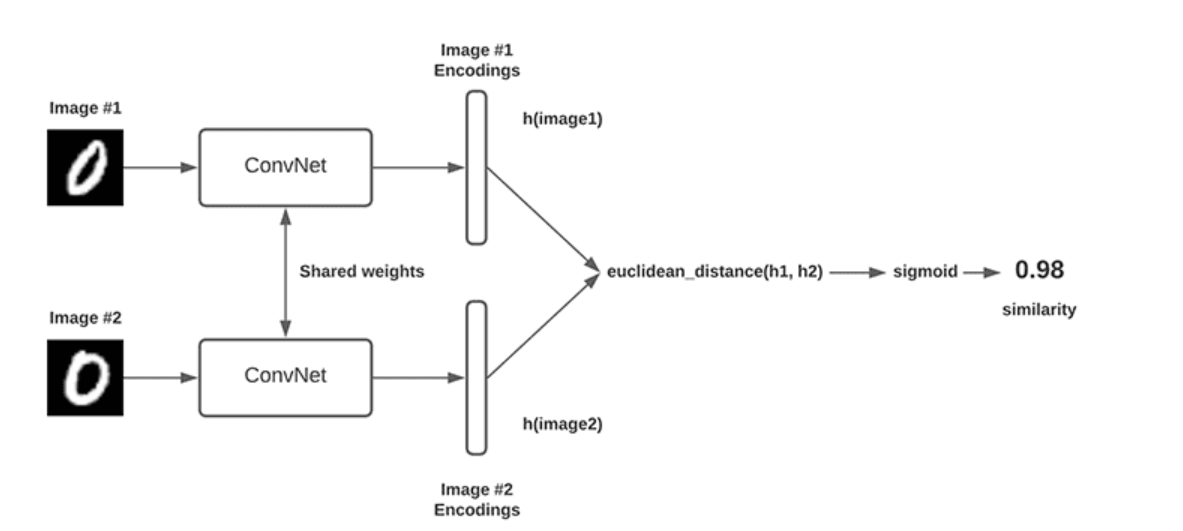


In [11]:
# Euclidean distance function
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

# Contrastive loss function
def contrastive_loss(y_true, y_pred, margin=1):
    y_true = tf.cast(y_true, y_pred.dtype)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def contrastive_accuracy(y_true, y_pred, threshold=0.5):
    return K.mean(K.equal(y_true, K.cast(y_pred < threshold, y_true.dtype)))

# Encoder building
def build_encoder(input_shape, n_filters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(n_filters, (5, 5), activation="relu", padding="valid")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(n_filters*2, (5, 5), activation="tanh", padding="valid")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(n_filters*8, (5, 5), activation="tanh", padding="valid")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    embeddings = layers.Dense(64, activation="relu")(x)
    # norm_embeddings = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=-1))(embeddings)
    return Model(inputs, embeddings, name="Encoder")


def train_siamese_network(X_train1, X_train2, y_train, n_filters=32, epochs=10):

    # Make sure images have explicit channels
    if len(X_train1.shape) == 3:
        X_train1 = X_train1[..., np.newaxis]
        X_train2 = X_train2[..., np.newaxis]

    input_shape = X_train1.shape[1:]
    encoder = build_encoder(input_shape, n_filters)

    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    encoded_a = encoder(input_a)
    encoded_b = encoder(input_b)

    merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [encoded_a, encoded_b])

    # normal_layer = keras.layers.BatchNormalization()(merge_layer)
    # output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
    siamese_net = keras.Model(inputs=[input_a, input_b], outputs=merge_layer)

    # binary_crossentropy
    # contrastive_loss

    siamese_net.compile(loss=contrastive_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[contrastive_accuracy])


    # train the model
    siamese_net.fit([X_train1, X_train2], y_train,
                    batch_size=16,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=True)

    # Save the model
    encoder.save("encoder_contrastive.h5")
    siamese_net.save("siamese_contrastive_model.h5")

    return encoder, siamese_net


In [12]:
def concatenate_images(imgs, labels, k):
    """
    Concatena gruppi di k immagini appartenenti alla stessa classe.

    Parameters:
        imgs: array [N, H, W, C]
        labels: array [N]
        k: number of images to be concatenated

    Output:
        images_concatenate: array of images [num_groups, H, W*k, C]
        labels_concatenate: array of labels associated with each group [num_groups]
    """
    if k < 2:
        return imgs, labels

    immagini_concatenate = []
    labels_concatenate = []

    classi, _ = np.unique(labels, return_counts=True)

    for c in classi:

        indici_classe = np.where(labels == c)[0]


        np.random.shuffle(indici_classe)

        # Form groups of k pictures
        num_blocchi = len(indici_classe) // k
        for i in range(num_blocchi):
            indici_blocco = indici_classe[i*k : (i+1)*k]
            immagini_blocco = imgs[indici_blocco]


            # Concatenate horizontally along the width axis (axis=1)
            immagine_concatenata = np.concatenate(immagini_blocco, axis=1)


            immagini_concatenate.append(immagine_concatenata)
            labels_concatenate.append(c)
        immagini_concatenate = [resize_image(img, fixed_size) for img in immagini_concatenate]

    return np.array(immagini_concatenate), np.array(labels_concatenate)



# main

In [13]:
# Path
path_X_test     = "Computational-vision-project/Dataset/zip dataset/test/*"
path_X_train    = "Computational-vision-project/Dataset/zip dataset/train/*"
path_our_data_X = "Computational-vision-project/data test/data test/X_test/*"

risultati_modello_1 = "/content/drive/MyDrive/computational_vision_condivisa/risultati/risultati_modello_1_nuovo_trash"
risultati_modello_2 = "/content/drive/MyDrive/computational_vision_condivisa/risultati/risultati_modello_2_nuovo_trash"


In [14]:
!rm -rf Computational-vision-project
!git clone https://github.com/Pietro-Panizza/Computational-vision-project.git
os.listdir("Computational-vision-project/Dataset/zip dataset")

Cloning into 'Computational-vision-project'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 22 (from 1)
Receiving objects: 100% (25/25), 79.01 MiB | 20.84 MiB/s, done.


['CERUG-EN-test-images.tar.gz', 'CERUG-EN-train-images.tar.gz']

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# ############################# DATASET 1 ####################

#uncomment and insert the right path

zip_path1 = "Computational-vision-project/Dataset/zip dataset/CERUG-EN-train-images.tar.gz"
estrazione_path1 = "Computational-vision-project/Dataset/zip dataset"
shutil.unpack_archive(zip_path1, estrazione_path1)

zip_path2 = "Computational-vision-project/Dataset/zip dataset/CERUG-EN-test-images.tar.gz"
estrazione_path2 = "Computational-vision-project/Dataset/zip dataset"
shutil.unpack_archive(zip_path2, estrazione_path2)



In [17]:
# load the dataset
X_train = io.imread_collection(path_X_train)
X_test = io.imread_collection(path_X_test)
data_our_test = io.imread_collection(path_our_data_X)

Y_test_our = np.array([0,0,1,1])
print("data_our_test len: ", len(data_our_test))
print("X_train len: ", len(X_train))
print("X_test len: ", len(X_test))


print(os.path.basename(X_train.files[0]))
print(os.path.basename(X_test.files[0]))

print(os.path.basename(X_train.files[-1]))
print(os.path.basename(X_test.files[-1]))

# As the labels are the names of the images themselves, I use extract masck to create
# a vector Y in which labels are associated according to the name of the photos

Y_train = extraxt_label(X_train,10)
Y_test  = extraxt_label(X_test,10)

print("\nX_train: ", len(X_train))
print("Y_train: ", len(Y_train))

print("\nX_test: ",len(X_test))
print("Y_test: ", len(Y_test))

print(np.unique(Y_train),"\n")
print(np.unique(Y_test))

data_our_test len:  4
X_train len:  5702
X_test len:  5127
Writer0101_03-01-line-0-n-0-y-32-x-164-h-103-w-80.png
Writer0101_03-02-line-0-n-0-y-91-x-123-h-96-w-64.png
Writer9999_03-01-line-4-n-7-y-686-x-1652-h-109-w-159.png
Writer9999_03-02-line-3-n-10-y-555-x-2044-h-100-w-77.png
Same dimension
Same dimension

X_train:  5702
Y_train:  5702

X_test:  5127
Y_test:  5127
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104] 

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  4

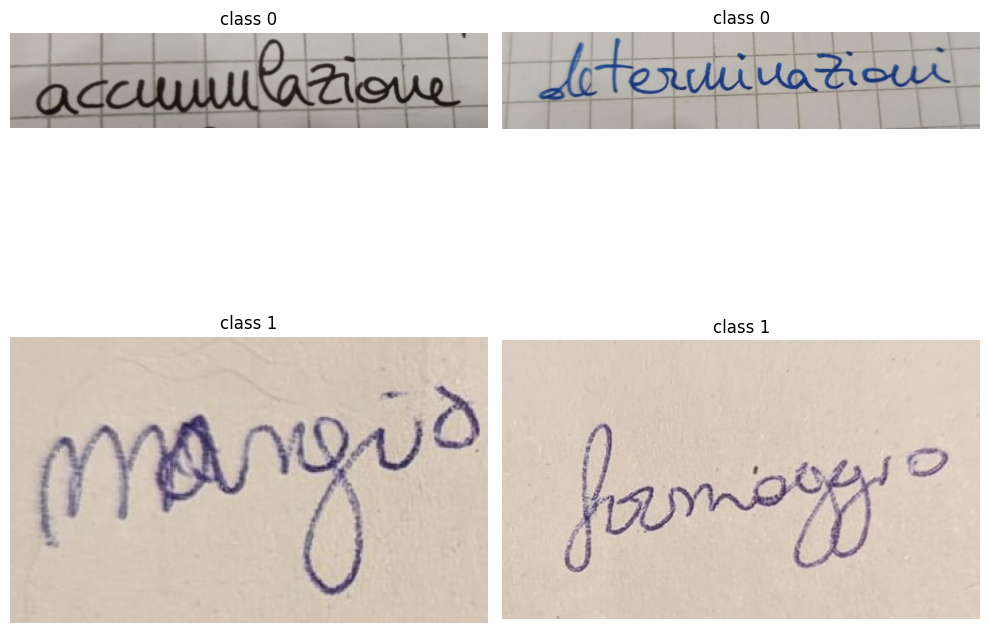

In [18]:


if len(data_our_test) == 4:
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 griglia

    # Rotate the first two images (0,0) and (0,1) 90° clockwise
    ax[0, 0].imshow(np.rot90(data_our_test[0], k=1))
    ax[0, 0].axis('off')
    ax[0, 0].set_title("class 0")

    ax[0, 1].imshow(np.rot90(data_our_test[1], k=1))
    ax[0, 1].axis('off')
    ax[0, 1].set_title("class 0")

    # The other two normal images
    ax[1, 0].imshow(data_our_test[2])
    ax[1, 0].axis('off')
    ax[1, 0].set_title("class 1")

    ax[1, 1].imshow(data_our_test[3])
    ax[1, 1].axis('off')
    ax[1, 1].set_title("class 1")

    plt.tight_layout()
    plt.show()
else:
    print("Errore: non ci sono esattamente 4 immagini.")


In [19]:
data_our_test = [resize_image(img, fixed_size) for img in data_our_test]
data_our_test = [cv.cvtColor(img, cv.COLOR_BGR2GRAY) if len(img.shape) == 3 else img for img in data_our_test]


data_our_test[0] = imutils.rotate(data_our_test[0], angle=90)
data_our_test[1] = imutils.rotate(data_our_test[1], angle=90)


In [20]:
#our image and pairs
X_pairs_our = [ (data_our_test[0],data_our_test[1],1),
                (data_our_test[2],data_our_test[3],1),
                (data_our_test[0],data_our_test[2],0),
                (data_our_test[0],data_our_test[3],0),
                (data_our_test[2],data_our_test[3],0),
                (data_our_test[2],data_our_test[3],0),
                (data_our_test[1],data_our_test[2],0),
                (data_our_test[1],data_our_test[3],0),
                ]

X_pairs_our_images = [(pair[0], pair[1]) for pair in X_pairs_our]
Y_pairs_our = np.array([pair[2] for pair in X_pairs_our])
X1_write_pairs_test_our, X2_write_pairs_test_our, Y_write_pairs_test_our= preparation_data(X_pairs_our_images, Y_pairs_our)

X1_write_pairs_test_our = np.expand_dims(X1_write_pairs_test_our, axis=-1)
X2_write_pairs_test_our = np.expand_dims(X2_write_pairs_test_our, axis=-1)

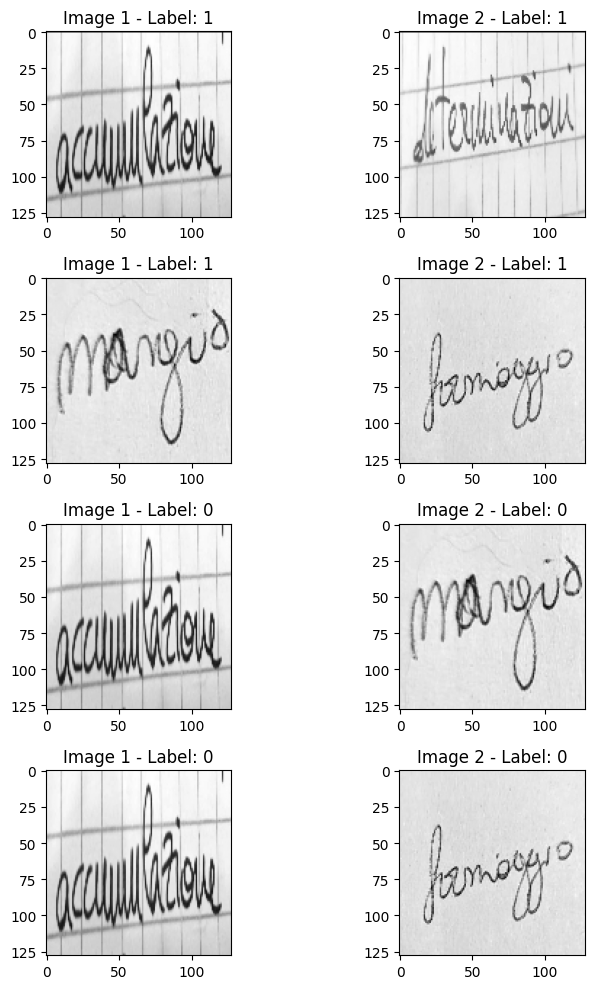

In [21]:
fig, ax = plt.subplots(4,2, figsize=(8,10)) # Create a 4x2 grid of subplots

for i in range(4):
  x,y,label = X_pairs_our[i]

  # Plot on the Axes in the i-th row
  ax[i, 0].imshow(x, cmap = "gray")
  ax[i, 0].set_title(f"Image 1 - Label: {label}") # Set title on the first image

  ax[i, 1].imshow(y,cmap = "gray")
  ax[i, 1].set_title(f"Image 2 - Label: {label}") # Set title on the second image

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [22]:
# to see what a whole sentence written by someone looks like
mostra = False
if mostra == True:
  X_tr_1 = [X_train[i] for i in range(len(X_train)) if Y_train[i] == 0]
  fig, ax = plt.subplots(10,6,figsize = (13,13))

  # Calculate the number of columns
  num_cols = ax.shape[1]

  for row in range(ax.shape[0]):
    for col in range(num_cols):
      # Calculate the linear index for the image
      img_index = row * num_cols + col
      # Check if the index is within the bounds of X_tr_1
      if img_index < len(X_tr_1):
          ax[row,col].imshow(X_tr_1[img_index])
      else:
          # If there are fewer images than subplots, break the inner loop
          break
    # If we broke the inner loop, also break the outer loop
    if img_index >= len(X_tr_1):
        break

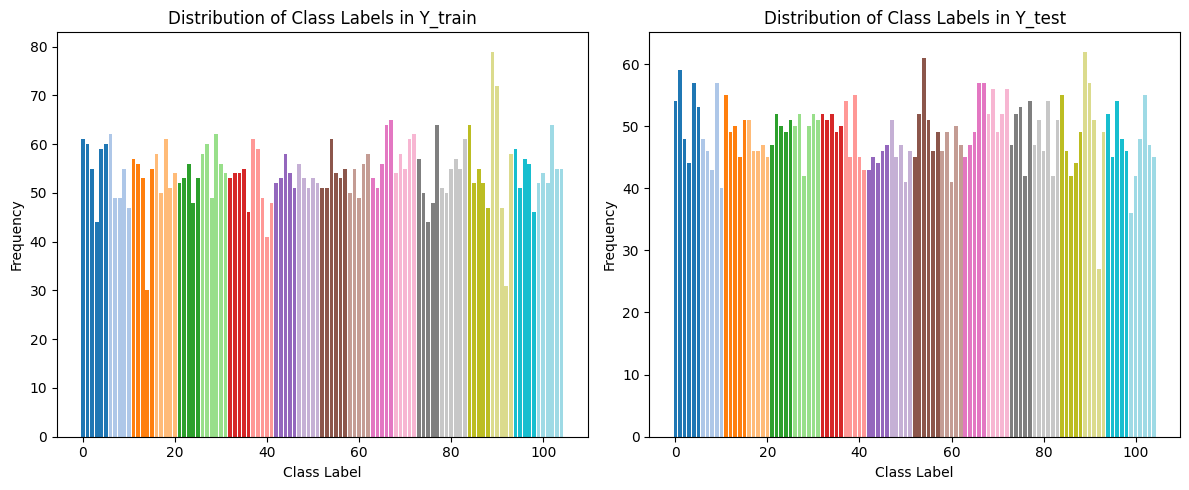

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # Create a figure with 2 subplots
# Plot histograms on the respective subplots
plot_hist(axes[0], Y_train, "Y_train")
plot_hist(axes[1], Y_test, "Y_test")

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

i dati ora sono encodati come

Y_train_positive = [(img1_pos,img1_pos, 1),...(imgn_pos,imgn_pos, 1)]

Y_train_negative = [(img1_pos,img1_neg, 0),...(imgn_pos,imgn_neg, 0)]

# parameter

In [24]:
# parameter to test

class_used_train2_V = [10,20,30]
class_used_test2,sample_test2 = 5, 5
sample_train2_V = [3,6] #3,
attached_image2_V = [1,2,3]
distance_trashold = 5   #estimate with more run

#no back ground analysis

#model one

In [ ]:
for class_used_train2 in class_used_train2_V:
  for sample_train2 in sample_train2_V :

    for attached_image2 in attached_image2_V:

      seed_value = class_used_train2 * 1000 + sample_train2 * 100 + attached_image2
      np.random.seed(seed_value)

      # building training and test set
      print(f"\n--- Setup: classes={class_used_train2}, sample={sample_train2}, attached={attached_image2} ---")

      x_traina, y_traina = choose_sample_from_class(X_train,Y_train, class_used_train2, sample_train2*attached_image2, fixed_size) #--> takes m samples for n class
      x_testa, y_testa = choose_sample_from_class(X_test,Y_test, class_used_test2, sample_test2*attached_image2, fixed_size) #--> takes m samples for n class

      #concatenate
      x_train2, y_train2 = concatenate_images(x_traina, y_traina, attached_image2)
      x_test2, y_test2 =   concatenate_images(x_testa, y_testa, attached_image2)


      # Check labels after updating
      p, counts = np.unique(y_train2, return_counts=True)


      p, counts = np.unique(y_test2, return_counts=True)


      # images pairs
      X_pairs_train2, Y_pairs_train2= make_pairs(x_train2, y_train2)
      X_pairs_test2, Y_pairs_test2 = make_pairs(x_test2, y_test2)


      # add an other dimension for gray channel
      X1_write_pairs_train2, X2_write_pairs_train2, Y_write_pairs_train2 = preparation_data(X_pairs_train2, Y_pairs_train2)
      X1_write_pairs_test2, X2_write_pairs_test2, Y_write_pairs_test2= preparation_data(X_pairs_test2, Y_pairs_test2)


      encoder, siamese_net = train_siamese_network(X1_write_pairs_train2, X2_write_pairs_train2, Y_write_pairs_train2, n_filters=32, epochs=20)

      # Prediction on the test set
      distance_pred = siamese_net.predict([X1_write_pairs_test2, X2_write_pairs_test2])
      y_pred2 = (distance_pred < distance_trashold).astype(int) #set 1 if distance is <0.5

      conta2 = 0
      for i in range(len(y_pred2)):
        if y_pred2[i] == Y_write_pairs_test2[i]:
          conta2 = conta2 +1

      accuracy2 = conta2 / len(y_pred2)

      # Prediction on test_our
      distance_pred_our = siamese_net.predict([X1_write_pairs_test_our, X2_write_pairs_test_our])  # Probabilità (float tra 0 e 1)
      y_pred2_our = (distance_pred_our < distance_trashold).astype(int)

      conta_our = 0
      for i in range(len(y_pred2_our)):
        if y_pred2_our[i] == Y_write_pairs_test_our[i]:
          conta_our = conta_our +1

      accuracy_our = conta_our / len(y_pred2_our)

      # Save results
      # Print some predictions
      print(f"\n sample for train {sample_train2} | classes for train {class_used_train2} | accuracy for our data: {accuracy_our} | accuracy for data: {accuracy2}")
      for i in range(len(y_pred2_our)):  #stamp
          print(f" Predetto: {y_pred2_our[i][0]} | Reale: {Y_write_pairs_test_our[i]} | distance : {distance_pred_our[i]}")

      # Write to file in append mode (add to bottom)
      with open(risultati_modello_1, "a") as f:  #stamp cerug
          f.write(f"sample for each class: {sample_train2} | classes for training: {class_used_train2} | attached images: {attached_image2} | total accuracy: {accuracy2} \n")
          for i in range(3):
              f.write(f"pred: {y_pred2[i][0]} | True y: {Y_write_pairs_test2[i]} | y pred prob: {distance_pred[i]}\n")
          f.write(f"sample for each class: {sample_train2} | classes for training: {class_used_train2} | attached images: {attached_image2} | total our accuracy: {accuracy_our} \n")
          for i in range(len(y_pred2_our)):#stamp our
              f.write("our sample")
              f.write(f" pred: {y_pred2_our[i][0]} | real: {Y_write_pairs_test_our[i]} | distance : {distance_pred_our[i]} | \n")
          f.write("--------------------------------------------------\n")


--- Setup: classes=10, sample=3, attached=1 ---
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 434ms/step - contrastive_accuracy: 0.9321 - loss: 7.3619 - val_contrastive_accuracy: 0.7590 - val_loss: 0.3767
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - contrastive_accuracy: 0.7403 - loss: 1.7864 - val_contrastive_accuracy: 0.7963 - val_loss: 0.9375
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - contrastive_accuracy: 0.6266 - loss: 3.9175 - val_contrastive_accuracy: 0.8348 - val_loss: 67.7167
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - contrastive_accuracy: 0.1597 - loss: 1.2887 - val_contrastive_accuracy: 0.8348 - val_loss: 2211.6702
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - contrastive_accuracy: 0.1274 - loss: 3.4454 - val_contrastive_accuracy: 0.8348 - val_loss: 177.3713
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - contrastive_accuracy: 0.8612 - loss: 2.1212 - val_contrastive_accuracy: 0.8348 - val_loss: 1615.7970
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step

 sample for train 3 | classes for train 10 | accuracy for our data: 0.75 | accuracy for data: 0.8333333333333334
 Predetto: 0 | Reale: 1 | distance : [25.598276]
 Predetto: 0 | Reale: 1 | distance : [55.861416]
 Predetto: 0 | Reale: 0 | distance : [54.36682]
 Predetto: 0 | Reale: 0 | distance : [106.856285]
 Predetto: 0 | Reale: 0 | distance : [55.861416]
 Predetto: 0 | Reale: 0 | distance : [55.861416]
 Predetto: 0 | Reale: 0 | distance : [29.720755]
 Predetto: 0 | Reale: 0 | distance : [83.85346]

--- Setup: classes=10, sample=3, attached=2 ---
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 387ms/step - contrastive_accuracy: 0.9181 - loss: 4.1832 - val_contrastive_accuracy: 0.8348 - val_loss: 0.7172
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - contrastive_accuracy: 0.2318 - loss: 1.6002 - val_contrastive_accuracy: 0.8348 - val_loss: 3.0503
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - contrastiv

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step

 sample for train 3 | classes for train 10 | accuracy for our data: 0.625 | accuracy for data: 0.16666666666666666
 Predetto: 0 | Reale: 1 | distance : [21.835747]
 Predetto: 1 | Reale: 1 | distance : [4.6022816]
 Predetto: 0 | Reale: 0 | distance : [28.950474]
 Predetto: 0 | Reale: 0 | distance : [31.764423]
 Predetto: 1 | Reale: 0 | distance : [4.6022816]
 Predetto: 1 | Reale: 0 | distance : [4.6022816]
 Predetto: 0 | Reale: 0 | distance : [7.8489776]
 Predetto: 0 | Reale: 0 | distance : [11.2206335]

--- Setup: classes=10, sample=3, attached=3 ---
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 360ms/step - contrastive_accuracy: 0.9264 - loss: 6.1145 - val_contrastive_accuracy: 0.8348 - val_loss: 7.8677
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - contrastive_accuracy: 0.8759 - loss: 13.3764 - val_contrastive_accuracy: 0.8348 - val_loss: 35.4701
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - cont

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step

 sample for train 3 | classes for train 10 | accuracy for our data: 0.75 | accuracy for data: 0.38
 Predetto: 0 | Reale: 1 | distance : [19.773968]
 Predetto: 0 | Reale: 1 | distance : [17.796389]
 Predetto: 0 | Reale: 0 | distance : [11.294901]
 Predetto: 0 | Reale: 0 | distance : [28.230719]
 Predetto: 0 | Reale: 0 | distance : [17.796389]
 Predetto: 0 | Reale: 0 | distance : [17.796389]
 Predetto: 0 | Reale: 0 | distance : [9.092631]
 Predetto: 0 | Reale: 0 | distance : [8.968306]

--- Setup: classes=10, sample=6, attached=1 ---
Epoch 1/20


# print results model one

In [ ]:
total_text = []
with open(risultati_modello_1,"r")    as f:
  for row in f:
          total_text.append(row.strip())
f.close()

In [ ]:
total_text1 = [] #--> container of all the text
with open(risultati_modello_1,"r")    as f:
  for row in f:
          total_text1.append(row.strip())
f.close()

In [ ]:
#take the data in for each
text_split_our1 = []
for i in range(4,len(total_text1),14): #informations are each 14 row but starts from 4, are result about normal test
  text_split_our1.append(total_text1[i:i+14])

#take only the sentence where there are the main information
vettore_con_risultati_our1 = []
for i in range(len(text_split_our1)):
  vettore_con_risultati_our1.append(text_split_our1[i][0]) # take only the first sentece that correspond to "sample, accuracy, pred, attach etc... " for each test
vettore_con_risultati_our1

['sample for each class: 3 | classes for training: 10 | attached images: 1 | total our accuracy: 0.25',
 'sample for each class: 3 | classes for training: 10 | attached images: 2 | total our accuracy: 0.25',
 'sample for each class: 3 | classes for training: 10 | attached images: 3 | total our accuracy: 0.625',
 'sample for each class: 6 | classes for training: 10 | attached images: 1 | total our accuracy: 0.75',
 'sample for each class: 6 | classes for training: 10 | attached images: 2 | total our accuracy: 0.25',
 'sample for each class: 6 | classes for training: 10 | attached images: 3 | total our accuracy: 0.75',
 'sample for each class: 3 | classes for training: 20 | attached images: 1 | total our accuracy: 0.25',
 'sample for each class: 3 | classes for training: 20 | attached images: 2 | total our accuracy: 0.5',
 'sample for each class: 3 | classes for training: 20 | attached images: 3 | total our accuracy: 0.25',
 'sample for each class: 6 | classes for training: 20 | attached

In [ ]:
#take the data in for each

text_acc_our1 = []
for i in range(0,len(total_text1),14):
  text_acc_our1.append(total_text1[i:i+5])

#take only the sentence where there are the main information
vettore_con_risultati1 = []
for i in range(len(text_acc_our1)):
  vettore_con_risultati1.append(text_acc_our1[i][0]) # take only the first sentece that correspond to "sample, accuracy, pred, attach etc... " for each test
vettore_con_risultati1

['sample for each class: 3 | classes for training: 10 | attached images: 1 | total accuracy: 0.16666666666666666',
 'sample for each class: 3 | classes for training: 10 | attached images: 2 | total accuracy: 0.16666666666666666',
 'sample for each class: 3 | classes for training: 10 | attached images: 3 | total accuracy: 0.16666666666666666',
 'sample for each class: 6 | classes for training: 10 | attached images: 1 | total accuracy: 0.16666666666666666',
 'sample for each class: 6 | classes for training: 10 | attached images: 2 | total accuracy: 0.16666666666666666',
 'sample for each class: 6 | classes for training: 10 | attached images: 3 | total accuracy: 0.16666666666666666',
 'sample for each class: 3 | classes for training: 20 | attached images: 1 | total accuracy: 0.16666666666666666',
 'sample for each class: 3 | classes for training: 20 | attached images: 2 | total accuracy: 0.16666666666666666',
 'sample for each class: 3 | classes for training: 20 | attached images: 3 | tot

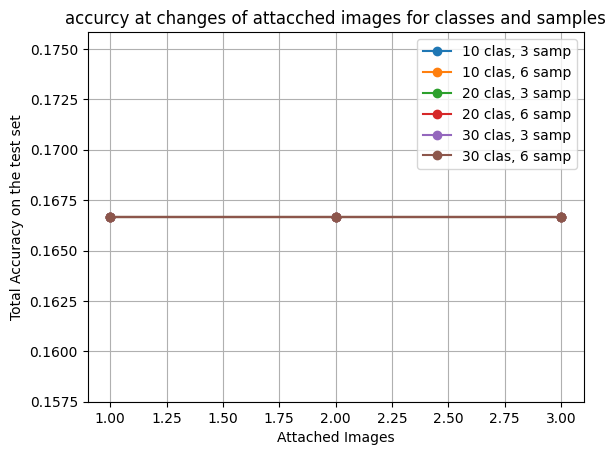

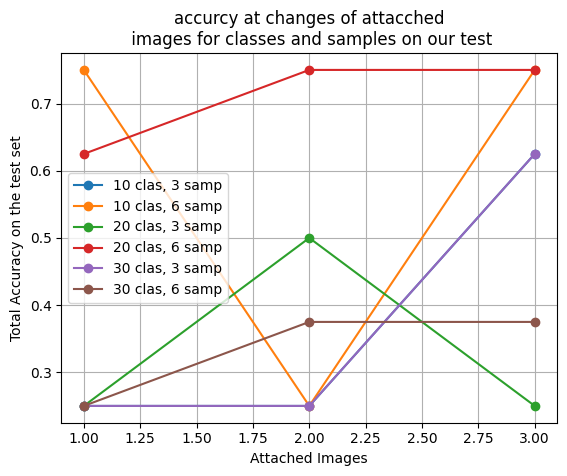

In [ ]:
# visualize the results using a dictionary
results_dict1 = dict_result(vettore_con_risultati1)

# Now the data are in the results_dict dictionary, e.g:
c_10_3 = results_dict1.get("classe_10_3", [])
c_10_6 = results_dict1.get("classe_10_6", [])
c_20_3 = results_dict1.get("classe_20_3", [])
c_20_6 = results_dict1.get("classe_20_6", [])
c_30_3 = results_dict1.get("classe_30_3", [])
c_30_6 = results_dict1.get("classe_30_6", [])


plot_multiple(c_10_3,c_10_6,c_20_3,c_20_6,c_30_3,c_30_6,"accurcy at changes of attacched images for classes and samples")


#accuracy in our test
results_dict_our1 = dict_result(vettore_con_risultati_our1)

# Now the data are in the results_dict dictionary, e.g:
c_10_3_our = results_dict_our1.get("classe_10_3", [])
c_10_6_our = results_dict_our1.get("classe_10_6", [])
c_20_3_our = results_dict_our1.get("classe_20_3", [])
c_20_6_our = results_dict_our1.get("classe_20_6", [])
c_30_3_our = results_dict_our1.get("classe_30_3", [])
c_30_6_our = results_dict_our1.get("classe_30_6", [])


plot_multiple(c_10_3_our,c_10_6_our,c_20_3_our,c_20_6_our,c_30_3_our,c_30_6_our,"accurcy at changes of attacched\n images for classes and samples on our test")

# with background analysis


## pre procecing

there is much noise --> use a gaussian filter and then reuse a trahsold

GaussianBlur --> stimate by own the variance


take a patch, evalueate the everage and sotrract the value of C for make more difficult that one pixel will be consier true when its so near to bhe borderlines of the classification

es C = 0 if i have everage 10 with trashold 9 -->  10-0 > 9 true
C = 3 if i have everage 10 with trashold 9 -->  10-3 < 9 false

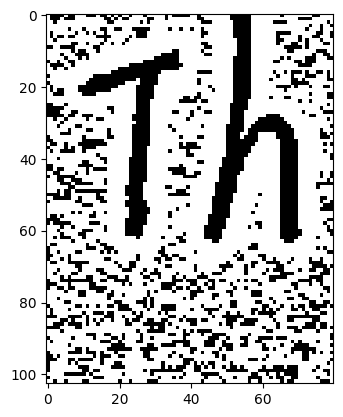

In [25]:
#example of what we want to do
img1_ = X_train[0]
img1_ = img1_ = cv.adaptiveThreshold(img1_, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                              cv.THRESH_BINARY, blockSize=11, C = 3)
plt.imshow(img1_, cmap = "gray")

use the otsu method with gaussian for take off the noise


apply to all the dataset for tring the model using the gray sacle and the no background datum


In [26]:
# makes our test set suitable for the model
data_our_test_tr = gauss_trash_ots(data_our_test)


X_pairs_our_tr = [ (data_our_test_tr[0],data_our_test_tr[1],1),
                (data_our_test_tr[2],data_our_test_tr[3],1),
                (data_our_test_tr[0],data_our_test_tr[2],0),
                (data_our_test_tr[0],data_our_test_tr[3],0),
                (data_our_test_tr[2],data_our_test_tr[3],0),
                (data_our_test_tr[2],data_our_test_tr[3],0),
                (data_our_test_tr[1],data_our_test_tr[2],0),
                (data_our_test_tr[1],data_our_test_tr[3],0),
                ]

#take the pairs
X_pairs_our_images_tr = [(pair[0], pair[1]) for pair in X_pairs_our_tr]
Y_pairs_our_tr = np.array([pair[2] for pair in X_pairs_our_tr])
X1_write_pairs_test_our_tr, X2_write_pairs_test_our_tr, Y_write_pairs_test_our_tr= preparation_data(X_pairs_our_images_tr, Y_pairs_our_tr)

#add new channel
X1_write_pairs_test_our = np.expand_dims(X1_write_pairs_test_our, axis=-1)
X2_write_pairs_test_our = np.expand_dims(X2_write_pairs_test_our, axis=-1)

156.0
174.0
182.0
182.0


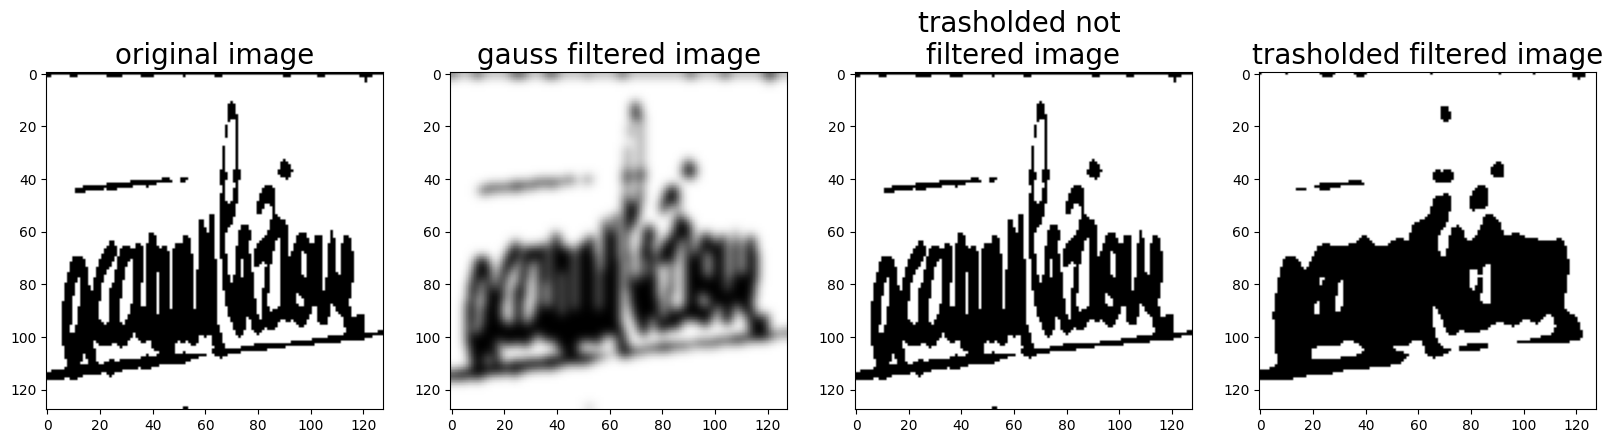

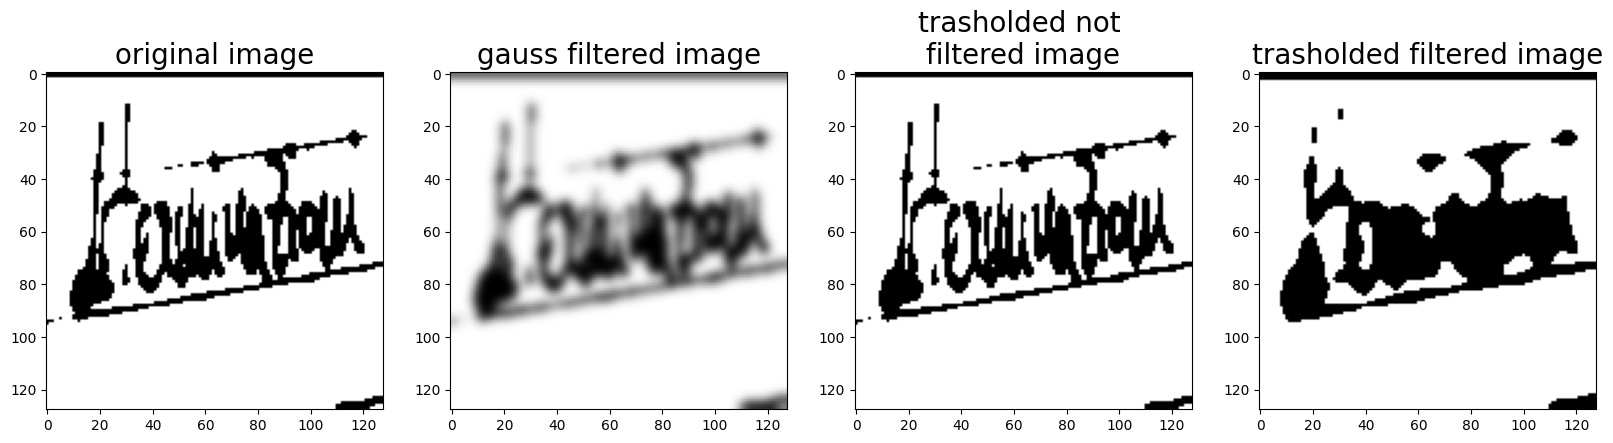

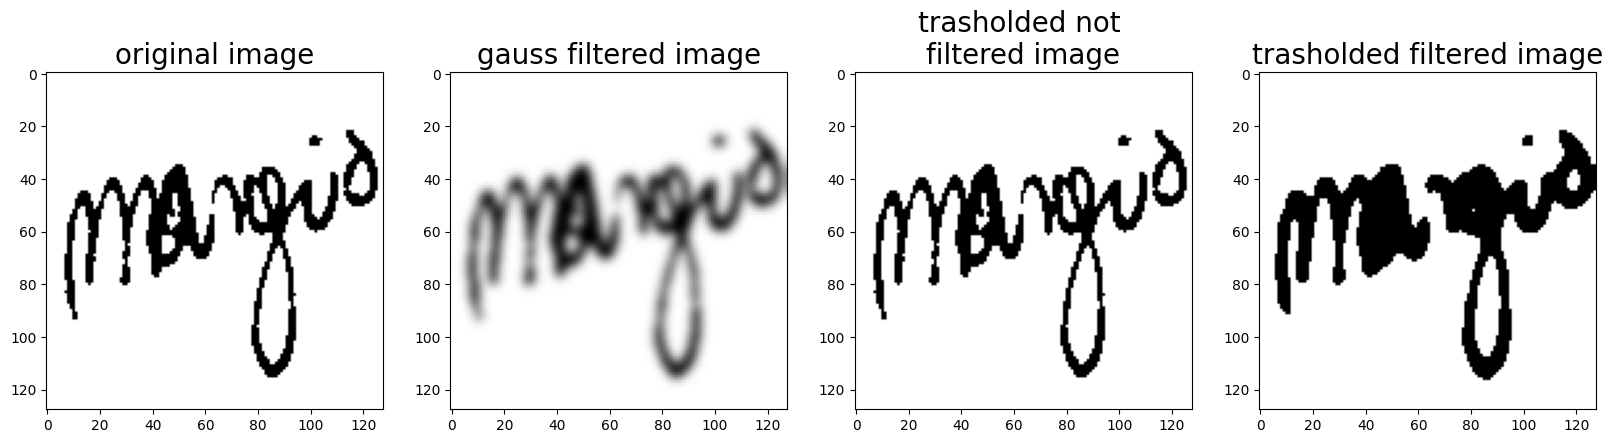

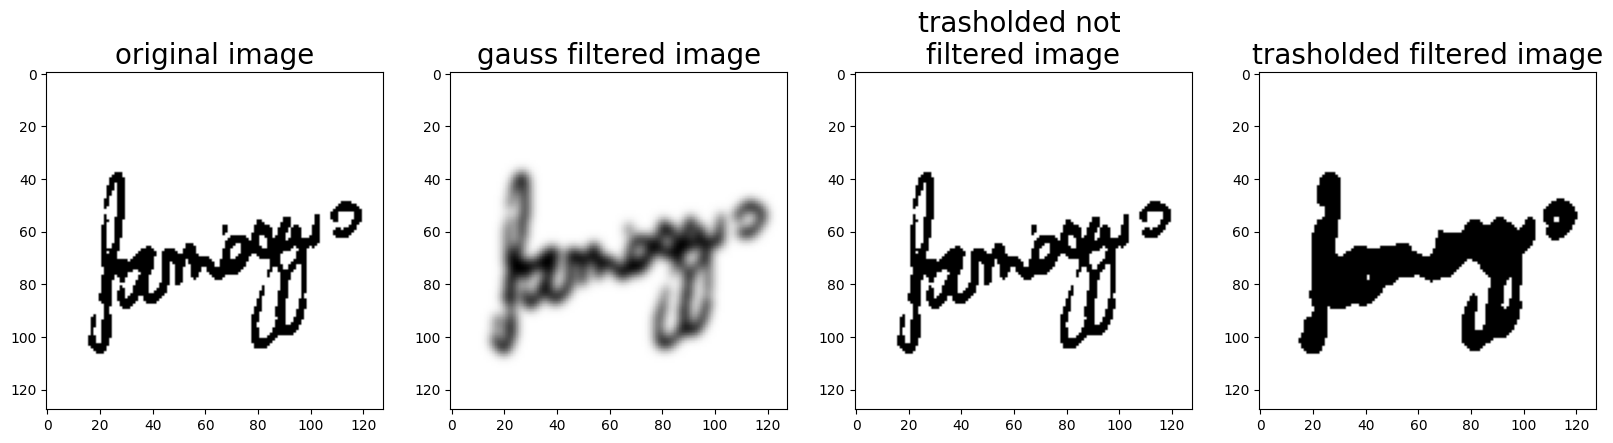

In [27]:
# how will present our datum
#understand how many channel have my data
for i in range(len(data_our_test)):
  img1 = data_our_test_tr[i]



  ret, trash_img_no_filt  = cv.threshold(img1, 0, 1, cv.THRESH_BINARY + # mak
                                              cv.THRESH_OTSU) # tahrashold

  img1_gauss = cv.GaussianBlur(img1,(11,11),0)
  ret, trash_img  = cv.threshold(img1_gauss, 0, 1, cv.THRESH_BINARY + # mak
                                              cv.THRESH_OTSU) # tahrashold
  print(ret)
  # trahsold background e image
  fig, ax = plt.subplots(1,4, figsize = (20,20))
  ax[0].imshow(img1, cmap = "gray")
  ax[0].set_title("original image",fontsize = 20)
  ax[1].imshow(img1_gauss, cmap = "gray")
  ax[1].set_title("gauss filtered image",fontsize = 20)
  ax[2].imshow(trash_img_no_filt, cmap = "gray")
  ax[2].set_title("trasholded not \nfiltered image", fontsize = 20)
  ax[3].imshow(trash_img, cmap = "gray")
  ax[3].set_title("trasholded filtered image",fontsize = 20)

## model two

In [28]:
class_used_test2 = 5
sample_test2 = 5
results = []

for class_used_train2 in class_used_train2_V:
  for sample_train2 in sample_train2_V :

    for attached_image2 in attached_image2_V:

      seed_value = class_used_train2 * 1000 + sample_train2 * 100 + attached_image2
      np.random.seed(seed_value)

      # building training and test set
      print(f"\n--- Setup: classes={class_used_train2}, sample={sample_train2}, attached={attached_image2} ---")

      x_trainb, y_trainb = choose_sample_from_class(X_train,Y_train, class_used_train2, sample_train2*attached_image2, fixed_size)
      x_testb, y_testb = choose_sample_from_class(X_test,Y_test, class_used_test2, sample_train2*attached_image2, fixed_size)

      #back gorun analisys
      x_trainb = gauss_trash_ots(x_trainb)
      x_testb = gauss_trash_ots(x_testb)

      #concatenating
      x_train, y_train = concatenate_images(x_trainb, y_trainb, attached_image2)
      x_test, y_test =   concatenate_images(x_testb, y_testb, attached_image2)

      #verify labels after update
      p, counts = np.unique(y_train, return_counts=True)

      p, counts = np.unique(y_test, return_counts=True)

      # coppie delle immagini
      X_pairs_train, Y_pairs_train= make_pairs(x_train, y_train)
      X_pairs_test, Y_pairs_test = make_pairs(x_test, y_test)

      # add an other dimension for gray channel
      X1_write_pairs_train, X2_write_pairs_train, Y_write_pairs_train = preparation_data(X_pairs_train,Y_pairs_train)
      X1_write_pairs_test, X2_write_pairs_test, Y_write_pairs_test= preparation_data(X_pairs_test,Y_pairs_test)

      encoder, siamese_net = train_siamese_network(X1_write_pairs_train, X2_write_pairs_train, Y_write_pairs_train, n_filters=32, epochs=20)

      # predictin on test set
      distance1 = siamese_net.predict([X1_write_pairs_test, X2_write_pairs_test])  # Probabilità (float tra 0 e 1)
      y_pred = (distance1 < distance_trashold).astype(int)

      conta = 0
      for i in range(len(y_pred)):
        if y_pred[i] == Y_write_pairs_test[i]:
          conta = conta +1

      accuracy = conta / len(y_pred)

      # prediction on test_our
      distance_pred_our1 = siamese_net.predict([X1_write_pairs_test_our_tr, X2_write_pairs_test_our_tr])  # Probabilità (float tra 0 e 1)
      y_pred_our1 = (distance_pred_our1 < distance_trashold).astype(int)

      conta_our1 = 0
      for i in range(len(y_pred_our1)):
        if y_pred_our1[i] == Y_write_pairs_test_our_tr[i]:
          conta_our1 = conta_our1 +1

      accuracy_our1 = conta_our1 / len(y_pred_our1)



      # stamp
      print(f"\n sample for train {sample_train2} | number class train {class_used_train2} | accuracy for our data: {accuracy_our1} | accuracy total data {accuracy}")
      for i in range(len(y_pred_our1)):  # stamp
          print(f" pred: {y_pred_our1[i][0]} | real: {Y_write_pairs_test_our_tr[i]} | distance : {distance_pred_our1[i]}")

      # load txt
      with open(risultati_modello_2, "a") as f:
          f.write(f"sample for each class: {sample_train2} | classes for training: {class_used_train2} | attached images: {attached_image2} | total accuracy: {accuracy}\n")
          for i in range(3): # stamp cerug test result
              f.write(f"pred: {y_pred[i][0]} | True y: {Y_write_pairs_test[i]} | y pred prob: {distance1[i]}\n")

          f.write(f"sample for each class: {sample_train2} | classes for training: {class_used_train2} | attached images: {attached_image2} | total our accuracy: {accuracy_our1} \n")
          for i in range(len(y_pred_our1)):  # stamp our test result
              f.write("our sample")
              f.write(f" pred: {y_pred_our1[i][0]} | real: {Y_write_pairs_test_our_tr[i]} | distance : {distance_pred_our1[i]} | \n")
          f.write("--------------------------------------------------\n")



--- Setup: classes=10, sample=3, attached=1 ---
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 506ms/step - contrastive_accuracy: 0.9191 - loss: 4.4884 - val_contrastive_accuracy: 0.7455 - val_loss: 18.5930
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - contrastive_accuracy: 0.3206 - loss: 1.1064 - val_contrastive_accuracy: 0.1652 - val_loss: 0.8621
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - contrastive_accuracy: 0.0560 - loss: 0.9440 - val_contrastive_accuracy: 0.1652 - val_loss: 0.8621
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - contrastive_accuracy: 0.0560 - loss: 0.9440 - val_contrastive_accuracy: 0.1652 - val_loss: 0.8621
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - contrastive_accuracy: 0.0560 - loss: 0.9440 - val_contrastive_accuracy: 0.1652 - val_loss: 0.8621
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - contrastive_accuracy: 0.0560 - loss: 0.9440 - val_contrastive_accuracy: 0.1652 - val_loss: 0.8621
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step

 sample for train 3 | number class train 10 | accuracy for our data: 0.625 | accuracy total data 0.5904761904761905
 pred: 1 | real: 1 | distance : [0.]
 pred: 0 | real: 1 | distance : [6.4706163]
 pred: 1 | real: 0 | distance : [0.]
 pred: 0 | real: 0 | distance : [6.4706163]
 pred: 0 | real: 0 | distance : [6.4706163]
 pred: 0 | real: 0 | distance : [6.4706163]
 pred: 1 | real: 0 | distance : [0.]
 pred: 0 | real: 0 | distance : [6.4706163]

--- Setup: classes=10, sample=3, attached=2 ---
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - contrastive_accuracy: 0.8365 - loss: 3.4573 - val_contrastive_accuracy: 0.6731 - val_loss: 0.6621
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - contrastive_accuracy: 0.8961 - loss: 1.9014 - val_contrastive_accuracy: 0.6887 - val_loss: 0.5180
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - contrastive_accuracy: 0.7293 - loss: 1.4267 - val_contrastive_accura

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step

 sample for train 3 | number class train 10 | accuracy for our data: 0.75 | accuracy total data 0.8380952380952381
 pred: 0 | real: 1 | distance : [15.690674]
 pred: 0 | real: 1 | distance : [288.19284]
 pred: 0 | real: 0 | distance : [89.819435]
 pred: 0 | real: 0 | distance : [363.78455]
 pred: 0 | real: 0 | distance : [288.19284]
 pred: 0 | real: 0 | distance : [288.19284]
 pred: 0 | real: 0 | distance : [86.59822]
 pred: 0 | real: 0 | distance : [361.2555]

--- Setup: classes=10, sample=3, attached=3 ---
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 425ms/step - contrastive_accuracy: 0.9144 - loss: 3.3678 - val_contrastive_accuracy: 0.1652 - val_loss: 0.8621
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - contrastive_accuracy: 0.0560 - loss: 0.9440 - val_contrastive_accuracy: 0.8314 - val_loss: 66.3419
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - contrastive_accuracy: 0.0560 - loss: 0.9440 - val

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step

 sample for train 3 | number class train 10 | accuracy for our data: 0.625 | accuracy total data 0.7714285714285715
 pred: 1 | real: 1 | distance : [0.]
 pred: 0 | real: 1 | distance : [60.004253]
 pred: 1 | real: 0 | distance : [4.084423]
 pred: 0 | real: 0 | distance : [64.07487]
 pred: 0 | real: 0 | distance : [60.004253]
 pred: 0 | real: 0 | distance : [60.004253]
 pred: 1 | real: 0 | distance : [4.084423]
 pred: 0 | real: 0 | distance : [64.07487]

--- Setup: classes=10, sample=6, attached=1 ---
Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - contrastive_accuracy: 0.4976 - loss: 3.1522 - val_contrastive_accuracy: 0.6236 - val_loss: 21.3141
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - contrastive_accuracy: 0.0606 - loss: 0.9394 - val_contrastive_accuracy: 0.2092 - val_loss: 0.8220
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - contrastive_accuracy: 0.0606 - loss: 0.9394 - val_contras

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step

 sample for train 6 | number class train 10 | accuracy for our data: 0.375 | accuracy total data 0.1724137931034483
 pred: 0 | real: 1 | distance : [6.5983396]
 pred: 1 | real: 1 | distance : [0.]
 pred: 0 | real: 0 | distance : [6.5983396]
 pred: 0 | real: 0 | distance : [6.5983396]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]

--- Setup: classes=10, sample=6, attached=2 ---
Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - contrastive_accuracy: 0.8166 - loss: 2.9450 - val_contrastive_accuracy: 0.7683 - val_loss: 1330.7839
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - contrastive_accuracy: 0.0606 - loss: 0.9394 - val_contrastive_accuracy: 0.7799 - val_loss: 2431.6699
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - contrastive_accuracy: 0.0606 - loss: 0.9394 - val_contrastive_accuracy: 0.7

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step

 sample for train 6 | number class train 10 | accuracy for our data: 0.75 | accuracy total data 0.8505747126436781
 pred: 0 | real: 1 | distance : [31.121828]
 pred: 0 | real: 1 | distance : [317.17767]
 pred: 0 | real: 0 | distance : [78.22861]
 pred: 0 | real: 0 | distance : [364.54013]
 pred: 0 | real: 0 | distance : [317.17767]
 pred: 0 | real: 0 | distance : [317.17767]
 pred: 0 | real: 0 | distance : [73.38043]
 pred: 0 | real: 0 | distance : [359.97174]

--- Setup: classes=10, sample=6, attached=3 ---
Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - contrastive_accuracy: 0.7921 - loss: 2.5933 - val_contrastive_accuracy: 0.7908 - val_loss: 1508.8296
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - contrastive_accuracy: 0.0668 - loss: 0.9605 - val_contrastive_accuracy: 0.7908 - val_loss: 1929.7164
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - contrastive_accuracy: 0.0606 - loss: 0.9394

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step

 sample for train 6 | number class train 10 | accuracy for our data: 0.875 | accuracy total data 0.7839080459770115
 pred: 1 | real: 1 | distance : [1.0047473]
 pred: 0 | real: 1 | distance : [87.57701]
 pred: 0 | real: 0 | distance : [5.6161046]
 pred: 0 | real: 0 | distance : [90.93446]
 pred: 0 | real: 0 | distance : [87.57701]
 pred: 0 | real: 0 | distance : [87.57701]
 pred: 0 | real: 0 | distance : [5.705274]
 pred: 0 | real: 0 | distance : [90.94001]

--- Setup: classes=20, sample=3, attached=1 ---
Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - contrastive_accuracy: 0.8521 - loss: 2.2305 - val_contrastive_accuracy: 0.2945 - val_loss: 2.6110
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - contrastive_accuracy: 0.0449 - loss: 2.6202 - val_contrastive_accuracy: 0.8886 - val_loss: 873.7272
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - contrastive_accuracy: 0.0237 - loss: 0.9763 - val_

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step

 sample for train 3 | number class train 20 | accuracy for our data: 0.625 | accuracy total data 0.4095238095238095
 pred: 1 | real: 1 | distance : [4.4256077]
 pred: 0 | real: 1 | distance : [7.8604903]
 pred: 1 | real: 0 | distance : [0.]
 pred: 0 | real: 0 | distance : [7.8604903]
 pred: 0 | real: 0 | distance : [7.8604903]
 pred: 0 | real: 0 | distance : [7.8604903]
 pred: 1 | real: 0 | distance : [4.4256077]
 pred: 0 | real: 0 | distance : [9.020716]

--- Setup: classes=20, sample=3, attached=2 ---
Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - contrastive_accuracy: 0.9558 - loss: 1.9094 - val_contrastive_accuracy: 0.8886 - val_loss: 1097.9912
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - contrastive_accuracy: 0.3291 - loss: 1.0648 - val_contrastive_accuracy: 0.8886 - val_loss: 3157.3337
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - contrastive_accuracy: 0.0264 - loss: 0.9735 - val

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step

 sample for train 3 | number class train 20 | accuracy for our data: 0.75 | accuracy total data 0.8571428571428571
 pred: 0 | real: 1 | distance : [95.027916]
 pred: 0 | real: 1 | distance : [390.85266]
 pred: 0 | real: 0 | distance : [212.41573]
 pred: 0 | real: 0 | distance : [572.5271]
 pred: 0 | real: 0 | distance : [390.85266]
 pred: 0 | real: 0 | distance : [390.85266]
 pred: 0 | real: 0 | distance : [157.09627]
 pred: 0 | real: 0 | distance : [517.56635]

--- Setup: classes=20, sample=3, attached=3 ---
Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - contrastive_accuracy: 0.9518 - loss: 2.6492 - val_contrastive_accuracy: 0.8886 - val_loss: 1061.3142
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - contrastive_accuracy: 0.8358 - loss: 2.1943 - val_contrastive_accuracy: 0.8886 - val_loss: 12033.6611
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - contrastive_accuracy: 0.0358 - loss: 1.583

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step

 sample for train 3 | number class train 20 | accuracy for our data: 0.375 | accuracy total data 0.14285714285714285
 pred: 0 | real: 1 | distance : [127.05766]
 pred: 1 | real: 1 | distance : [0.]
 pred: 0 | real: 0 | distance : [127.05766]
 pred: 0 | real: 0 | distance : [127.05766]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]

--- Setup: classes=20, sample=6, attached=1 ---
Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - contrastive_accuracy: 0.5834 - loss: 2.5590 - val_contrastive_accuracy: 0.7327 - val_loss: 2.1907
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - contrastive_accuracy: 0.0292 - loss: 0.9708 - val_contrastive_accuracy: 0.7857 - val_loss: 3.8016
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - contrastive_accuracy: 0.0292 - loss: 0.9708 - val_contrastive_accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step

 sample for train 6 | number class train 20 | accuracy for our data: 0.25 | accuracy total data 0.2620689655172414
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]

--- Setup: classes=20, sample=6, attached=2 ---
Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - contrastive_accuracy: 0.7734 - loss: 2.7790 - val_contrastive_accuracy: 0.1320 - val_loss: 0.8839
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - contrastive_accuracy: 0.0292 - loss: 0.9708 - val_contrastive_accuracy: 0.1000 - val_loss: 0.9076
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - contrastive_accuracy: 0.0292 - loss: 0.9708 - val_contrastive_accuracy: 0.1000 - val_loss: 0.907

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step

 sample for train 6 | number class train 20 | accuracy for our data: 0.25 | accuracy total data 0.1724137931034483
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]

--- Setup: classes=20, sample=6, attached=3 ---
Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - contrastive_accuracy: 0.7940 - loss: 1.2017 - val_contrastive_accuracy: 0.8169 - val_loss: 22.4434
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - contrastive_accuracy: 0.0292 - loss: 0.9708 - val_contrastive_accuracy: 0.8637 - val_loss: 74.2879
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - contrastive_accuracy: 0.0292 - loss: 0.9708 - val_contrastive_accuracy: 0.8637 - val_loss: 74.

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step

 sample for train 6 | number class train 20 | accuracy for our data: 0.625 | accuracy total data 0.4850574712643678
 pred: 1 | real: 1 | distance : [4.5830646]
 pred: 0 | real: 1 | distance : [40.165535]
 pred: 1 | real: 0 | distance : [4.493068]
 pred: 0 | real: 0 | distance : [38.333977]
 pred: 0 | real: 0 | distance : [40.165535]
 pred: 0 | real: 0 | distance : [40.165535]
 pred: 1 | real: 0 | distance : [4.264588]
 pred: 0 | real: 0 | distance : [39.686092]

--- Setup: classes=30, sample=3, attached=1 ---
Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - contrastive_accuracy: 0.9498 - loss: 1.9273 - val_contrastive_accuracy: 0.9338 - val_loss: 1654.7373
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - contrastive_accuracy: 0.6258 - loss: 1.9091 - val_contrastive_accuracy: 0.9338 - val_loss: 38905.5703
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - contrastive_accuracy: 0.9333 - loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step

 sample for train 3 | number class train 30 | accuracy for our data: 0.75 | accuracy total data 0.8571428571428571
 pred: 0 | real: 1 | distance : [176.55112]
 pred: 0 | real: 1 | distance : [332.02975]
 pred: 0 | real: 0 | distance : [498.3651]
 pred: 0 | real: 0 | distance : [768.4046]
 pred: 0 | real: 0 | distance : [332.02975]
 pred: 0 | real: 0 | distance : [332.02975]
 pred: 0 | real: 0 | distance : [419.10007]
 pred: 0 | real: 0 | distance : [717.07794]

--- Setup: classes=30, sample=3, attached=2 ---
Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - contrastive_accuracy: 0.9152 - loss: 1.1785 - val_contrastive_accuracy: 0.9049 - val_loss: 39.2785
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - contrastive_accuracy: 0.0507 - loss: 1.4230 - val_contrastive_accuracy: 0.3513 - val_loss: 5.0873
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - contrastive_accuracy: 0.0301 - loss: 0.9694

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step

 sample for train 3 | number class train 30 | accuracy for our data: 0.25 | accuracy total data 0.14285714285714285
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]

--- Setup: classes=30, sample=3, attached=3 ---
Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - contrastive_accuracy: 0.9481 - loss: 1.4020 - val_contrastive_accuracy: 0.9338 - val_loss: 1297.4882
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - contrastive_accuracy: 0.2965 - loss: 0.8975 - val_contrastive_accuracy: 0.9338 - val_loss: 47.8037
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - contrastive_accuracy: 0.9187 - loss: 0.8178 - val_contrastive_accuracy: 0.9338 - val_loss: 24

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step

 sample for train 3 | number class train 30 | accuracy for our data: 0.75 | accuracy total data 0.6666666666666666
 pred: 0 | real: 1 | distance : [6.6785774]
 pred: 0 | real: 1 | distance : [13.987209]
 pred: 0 | real: 0 | distance : [11.735799]
 pred: 0 | real: 0 | distance : [24.658298]
 pred: 0 | real: 0 | distance : [13.987209]
 pred: 0 | real: 0 | distance : [13.987209]
 pred: 0 | real: 0 | distance : [7.87112]
 pred: 0 | real: 0 | distance : [20.497149]

--- Setup: classes=30, sample=6, attached=1 ---
Epoch 1/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - contrastive_accuracy: 0.4479 - loss: 2.9589 - val_contrastive_accuracy: 0.0637 - val_loss: 0.9392
Epoch 2/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - contrastive_accuracy: 0.0186 - loss: 0.9814 - val_contrastive_accuracy: 0.0637 - val_loss: 0.9392
Epoch 3/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - contrastive_accuracy: 0.0186 - loss: 0.9814

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step

 sample for train 6 | number class train 30 | accuracy for our data: 0.25 | accuracy total data 0.2160919540229885
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]

--- Setup: classes=30, sample=6, attached=2 ---
Epoch 1/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - contrastive_accuracy: 0.4018 - loss: 1.2036 - val_contrastive_accuracy: 0.9329 - val_loss: 2947.7795
Epoch 2/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - contrastive_accuracy: 0.1608 - loss: 2.6640 - val_contrastive_accuracy: 0.1269 - val_loss: 11.6603
Epoch 3/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - contrastive_accuracy: 0.0416 - loss: 0.9574 - val_contrastive_accuracy: 0.1269 - val_loss: 6

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step

 sample for train 6 | number class train 30 | accuracy for our data: 0.25 | accuracy total data 0.1724137931034483
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]

--- Setup: classes=30, sample=6, attached=3 ---
Epoch 1/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - contrastive_accuracy: 0.8952 - loss: 0.9798 - val_contrastive_accuracy: 0.9363 - val_loss: 20410.3164
Epoch 2/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - contrastive_accuracy: 0.8961 - loss: 0.1988 - val_contrastive_accuracy: 0.9363 - val_loss: 1.4068
Epoch 3/20
806/806 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - contrastive_accuracy: 0.9722 - loss: 0.0432 - val_contrastive_accuracy: 0.9360 - val_loss: 0

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step

 sample for train 6 | number class train 30 | accuracy for our data: 0.25 | accuracy total data 0.1724137931034483
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 1 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]
 pred: 1 | real: 0 | distance : [0.]


## prit results model two

In [29]:
total_text = [] #--> container of all the text
with open(risultati_modello_2,"r")    as f:
  for row in f:
          total_text.append(row.strip())
          print(row)
f.close()

sample for each class: 3 | classes for training: 10 | attached images: 1 | total accuracy: 0.5904761904761905

pred: 0 | True y: 1.0 | y pred prob: [15.573505]

pred: 0 | True y: 1.0 | y pred prob: [22.09025]

pred: 0 | True y: 0.0 | y pred prob: [22.09025]

sample for each class: 3 | classes for training: 10 | attached images: 1 | total our accuracy: 0.625 

our sample pred: 1 | real: 1 | distance : [0.] | 

our sample pred: 0 | real: 1 | distance : [6.4706163] | 

our sample pred: 1 | real: 0 | distance : [0.] | 

our sample pred: 0 | real: 0 | distance : [6.4706163] | 

our sample pred: 0 | real: 0 | distance : [6.4706163] | 

our sample pred: 0 | real: 0 | distance : [6.4706163] | 

our sample pred: 1 | real: 0 | distance : [0.] | 

our sample pred: 0 | real: 0 | distance : [6.4706163] | 

--------------------------------------------------

sample for each class: 3 | classes for training: 10 | attached images: 2 | total accuracy: 0.8380952380952381

pred: 0 | True y: 1.0 | y pred p

In [30]:
#take the data in for each
text_split_our = []
for i in range(4,len(total_text),14): #informations are each 14 row but starts from 4, are result about normal test
  text_split_our.append(total_text[i:i+14])

#take only the sentence where there are the main information
vettore_con_risultati_our = []
for i in range(len(text_split_our)):
  vettore_con_risultati_our.append(text_split_our[i][0]) # take only the first sentece that correspond to "sample, accuracy, pred, attach etc... " for each test
vettore_con_risultati_our

['sample for each class: 3 | classes for training: 10 | attached images: 1 | total our accuracy: 0.625',
 'sample for each class: 3 | classes for training: 10 | attached images: 2 | total our accuracy: 0.75',
 'sample for each class: 3 | classes for training: 10 | attached images: 3 | total our accuracy: 0.625',
 'sample for each class: 6 | classes for training: 10 | attached images: 1 | total our accuracy: 0.375',
 'sample for each class: 6 | classes for training: 10 | attached images: 2 | total our accuracy: 0.75',
 'sample for each class: 6 | classes for training: 10 | attached images: 3 | total our accuracy: 0.875',
 'sample for each class: 3 | classes for training: 20 | attached images: 1 | total our accuracy: 0.625',
 'sample for each class: 3 | classes for training: 20 | attached images: 2 | total our accuracy: 0.75',
 'sample for each class: 3 | classes for training: 20 | attached images: 3 | total our accuracy: 0.375',
 'sample for each class: 6 | classes for training: 20 | at

In [31]:

#take the data in for each
text_split = []
for i in range(0,len(total_text),14): #informations are each 14 row but starts from 4, are result about normal test
  text_split.append(total_text[i:i+14])

#take only the sentence where there are the main information
vettore_con_risultati = []
for i in range(len(text_split)):
  vettore_con_risultati.append(text_split[i][0]) # take only the first sentece that correspond to "sample, accuracy, pred, attach etc... " for each test
vettore_con_risultati

['sample for each class: 3 | classes for training: 10 | attached images: 1 | total accuracy: 0.5904761904761905',
 'sample for each class: 3 | classes for training: 10 | attached images: 2 | total accuracy: 0.8380952380952381',
 'sample for each class: 3 | classes for training: 10 | attached images: 3 | total accuracy: 0.7714285714285715',
 'sample for each class: 6 | classes for training: 10 | attached images: 1 | total accuracy: 0.1724137931034483',
 'sample for each class: 6 | classes for training: 10 | attached images: 2 | total accuracy: 0.8505747126436781',
 'sample for each class: 6 | classes for training: 10 | attached images: 3 | total accuracy: 0.7839080459770115',
 'sample for each class: 3 | classes for training: 20 | attached images: 1 | total accuracy: 0.4095238095238095',
 'sample for each class: 3 | classes for training: 20 | attached images: 2 | total accuracy: 0.8571428571428571',
 'sample for each class: 3 | classes for training: 20 | attached images: 3 | total accur

test

classe_10_3 = [0.5904761904761905, 0.8380952380952381, 0.7714285714285715]
classe_10_6 = [0.1724137931034483, 0.8505747126436781, 0.7839080459770115]
classe_20_3 = [0.4095238095238095, 0.8571428571428571, 0.14285714285714285]
classe_20_6 = [0.2620689655172414, 0.1724137931034483, 0.4850574712643678]
classe_30_3 = [0.8571428571428571, 0.14285714285714285, 0.6666666666666666]
classe_30_6 = [0.2160919540229885, 0.1724137931034483, 0.1724137931034483]
our test

classe_10_3 = [0.625, 0.75, 0.625]
classe_10_6 = [0.375, 0.75, 0.875]
classe_20_3 = [0.625, 0.75, 0.375]
classe_20_6 = [0.25, 0.25, 0.625]
classe_30_3 = [0.75, 0.25, 0.75]
classe_30_6 = [0.25, 0.25, 0.25]


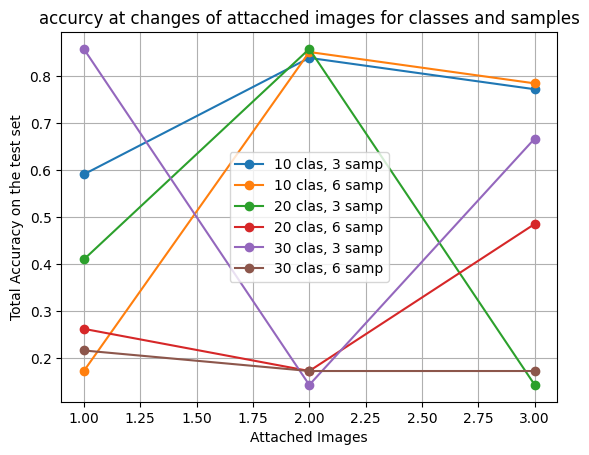

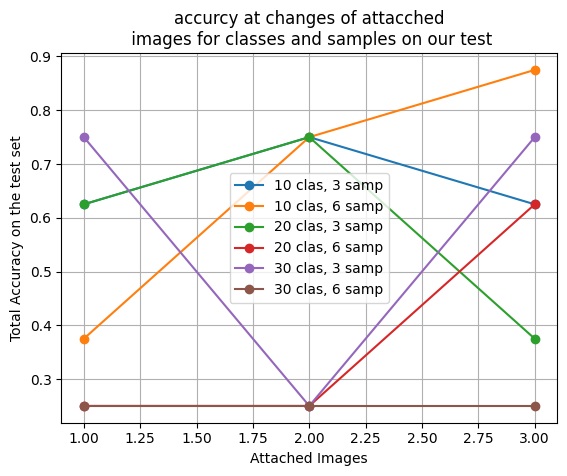

In [32]:
# visulaiza the results using a dict
results_dict = dict_result(vettore_con_risultati)

# Ora i dati sono nel dizionario results_dict, es:
c_10_3 = results_dict.get("classe_10_3", [])
c_10_6 = results_dict.get("classe_10_6", [])
c_20_3 = results_dict.get("classe_20_3", [])
c_20_6 = results_dict.get("classe_20_6", [])
c_30_3 = results_dict.get("classe_30_3", [])
c_30_6 = results_dict.get("classe_30_6", [])

print("test\n")
print("classe_10_3 =", c_10_3)
print("classe_10_6 =", c_10_6)
print("classe_20_3 =", c_20_3)
print("classe_20_6 =", c_20_6)
print("classe_30_3 =", c_30_3)
print("classe_30_6 =", c_30_6)



#accuracy in our test
results_dict_our = dict_result(vettore_con_risultati_our)

# Ora i dati sono nel dizionario results_dict, es:
c_10_3_our = results_dict_our.get("classe_10_3", [])
c_10_6_our = results_dict_our.get("classe_10_6", [])
c_20_3_our = results_dict_our.get("classe_20_3", [])
c_20_6_our = results_dict_our.get("classe_20_6", [])
c_30_3_our = results_dict_our.get("classe_30_3", [])
c_30_6_our = results_dict_our.get("classe_30_6", [])

print("our test\n")
print("classe_10_3 =", c_10_3_our)
print("classe_10_6 =", c_10_6_our)
print("classe_20_3 =", c_20_3_our)
print("classe_20_6 =", c_20_6_our)
print("classe_30_3 =", c_30_3_our)
print("classe_30_6 =", c_30_6_our)
plot_multiple(c_10_3,c_10_6,c_20_3,c_20_6,c_30_3,c_30_6,"accurcy at changes of attacched images for classes and samples")

plot_multiple(c_10_3_our,c_10_6_our,c_20_3_our,c_20_6_our,c_30_3_our,c_30_6_our,"accurcy at changes of attacched\n images for classes and samples on our test")